## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import re #(regular expression - a library useful for searching word in a paragraph)
import nltk
from nltk.corpus import stopwords # stopword- words that doesn't add much value of the paragraph , like -'the' ,'with' ,'i',etc.
from nltk.stem import WordNetLemmatizer # returns the root of a word by removing its prefix and suffix
from sklearn.feature_extraction.text import TfidfVectorizer # to convert text into feature vector (i.e numbers)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
# import xgboost as xgb
# from xgboost import XGBClassifier
# from sklearn import metrics
# from sklearn.metrics import accuracy_score

In [36]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\attila.matyi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\attila.matyi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\attila.matyi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [5]:
#Loading training dataset to pandas framework
df = pd.read_csv("train.csv")

In [6]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [9]:
df.shape

(6335, 4)

In [10]:
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

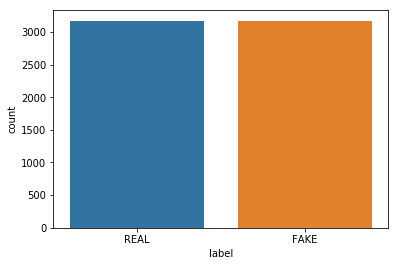

In [14]:
sns.countplot(data=df,
              x='label',
              order=df['label'].value_counts().index)

In [16]:
df.label[df.label == 'REAL'] = 1
df.label[df.label == 'FAKE'] = 0

C:\Users\attila.matyi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\attila.matyi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
# Merging 'title' and 'text' column in a new column 'body'
df['body']=df['text']+' '+df['title']

In [22]:
df.columns

Index(['Unnamed: 0', 'title', 'text', 'label', 'body'], dtype='object')

In [24]:
df = df.drop("Unnamed: 0",axis = 1)
df = df.drop("title",axis = 1)
df = df.drop("text",axis = 1)

In [28]:
def data_qualityCheck():
    print("Checking data qualitites...")
    df.isnull().sum()
    df.info()  
    print("check finished.")
data_qualityCheck()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 2 columns):
label    6335 non-null object
body     6335 non-null object
dtypes: object(2)
memory usage: 99.1+ KB
check finished.


# Text Cleaning

In [29]:
lemmatizer = WordNetLemmatizer()
stpwrds = list(stopwords.words('english'))

In [37]:
#lemmatization
for x in range(len(df)) :
    corpus = []
    review = df['body'][x]
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    for y in review :
        if y not in stpwrds :
            corpus.append(lemmatizer.lemmatize(y))
    review = ' '.join(corpus)
    df['body'][x] = review  

In [39]:
# Seperating the data and label
X =df['body'].values
Y =df['label'].astype('int').values

In [40]:
# Splitting the dataset to training and test data
X_train,X_test,Y_train,Y_test =train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=2)

In [44]:
X_train.shape

(5068,)

In [45]:
# Converting the textual data to numerical data using TfidfVectorizer
vectorizer =TfidfVectorizer()
tfidf_X_train = vectorizer.fit_transform(X_train)
tfidf_X_test = vectorizer.transform(X_test)

In [47]:
tfidf_X_train.shape

(5068, 67238)

# Model Training

In [48]:
# Function to plot the confusion matrix
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Model Training - Decision Tree Classifier



In [51]:
decision_model = DecisionTreeClassifier()
decision_model.fit(tfidf_X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Accuracy: 79.24%
Confusion matrix, without normalization


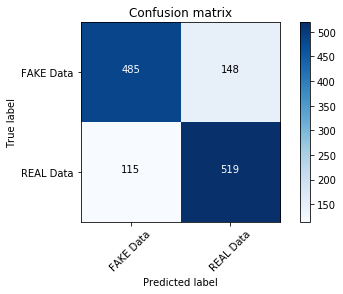

In [52]:
#accuracy score on the test data
Y_pred = decision_model.predict(tfidf_X_test)
score = metrics.accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {round(score*100,2)}%')
cm = metrics.confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

## CLASSIFICATION MODEL - PASSIVE AGGRESSIVE CLASSIFIER

In [49]:
classifier = PassiveAggressiveClassifier(max_iter=1000)
classifier.fit(tfidf_X_train,Y_train)

C:\Users\attila.matyi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              early_stopping=False, fit_intercept=True, loss='hinge',
              max_iter=1000, n_iter=None, n_iter_no_change=5, n_jobs=None,
              random_state=None, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False)

Accuracy: 93.61%
Confusion matrix, without normalization


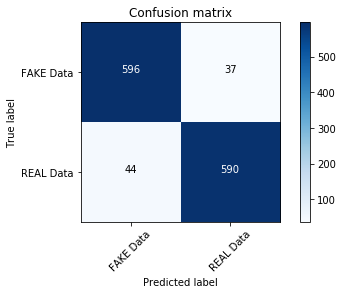

In [50]:
#accuracy score on the test data
Y_pred = classifier.predict(tfidf_X_test)
score = metrics.accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {round(score*100,2)}%')
cm = metrics.confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])